# Deep Fashion 2 visualization

In [1]:
from typing import List

import skimage.io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from masks import get_mask
from data_loader import load_training_df
from visualization import display_instances

In [4]:
dataset_path = '../data/fs2'

## Read dataset

Read images and annotations in training.

In [5]:
df = load_training_df(dataset_path)

In [6]:
df.shape

(52490, 13)

Map ordinal categories (e.g. scale, occlusion and viewpoint) into categorical columns for better understanding (values according to documentation).

In [7]:
df['scale_categorical'] = df['scale'].map(
    {1: 'small_scale', 2: 'modest_scale', 3: 'large_scale'}
)
df['zoom_in_categorical'] = df['zoom_in'].map(
    {1: 'no_zoom_in', 2: 'medium_zoom_in', 3: 'large_zoom_in'}
)
df['viewpoint_categorical'] = df['viewpoint'].map(
    {1: 'no_wear', 2: 'frontal_viewpoint', 3: 'side_or_back_viewpoint'}
)
df['occlusion_categorical'] = df['occlusion'].map(
    {1: 'slight_occlusion', 2: 'medium_occlusion', 3: 'heavy_occlusion'}
)

Let's visualize some examples.

In [8]:
df.sample(3)

segmentation  scale  viewpoint  \
id                                                                           
14851  [[214.2941008695083, 460.8625329019746, 237.85...      2          2   
21715  [[109.54285714285714, 484.45714285714286, 149....      2          2   
29358  [[174.72493379196982, 3.008858177833269, 175.0...      1          2   

       zoom_in                                          landmarks  style  \
id                                                                         
14851        3  [214, 461, 1, 308, 493, 1, 399, 534, 1, 90, 65...      0   
21715        3  [112, 485, 1, 199, 510, 1, 299, 506, 1, 113, 6...      0   
29358        3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0   

               bounding_box  category_id  occlusion    category_name source  \
id                                                                            
14851    [1, 458, 409, 959]            9          2            skirt   shop   
21715  [100, 479, 312, 701]            8          2         trousers   shop   
29358     [170, 2, 577, 83]            2          1  long sleeve top   shop   

       pair_id                    image_path scale_categorical  \
id                                                               
14851      452  ../data/fs2\image\014851.jpg      modest_scale   
21715     1228  ../data/fs2\image\021715.jpg      modest_scale   
29358     2071  ../data/fs2\image\029358.jpg       small_scale   

      zoom_in_categorical viewpoint_categorical occlusion_categorical  
id                                                                     
14851       large_zoom_in     frontal_viewpoint      medium_occlusion  
21715       large_zoom_in     frontal_viewpoint      medium_occlusion  
29358       large_zoom_in     frontal_viewpoint      slight_occlusion

## Data visualization

### Display image by category id

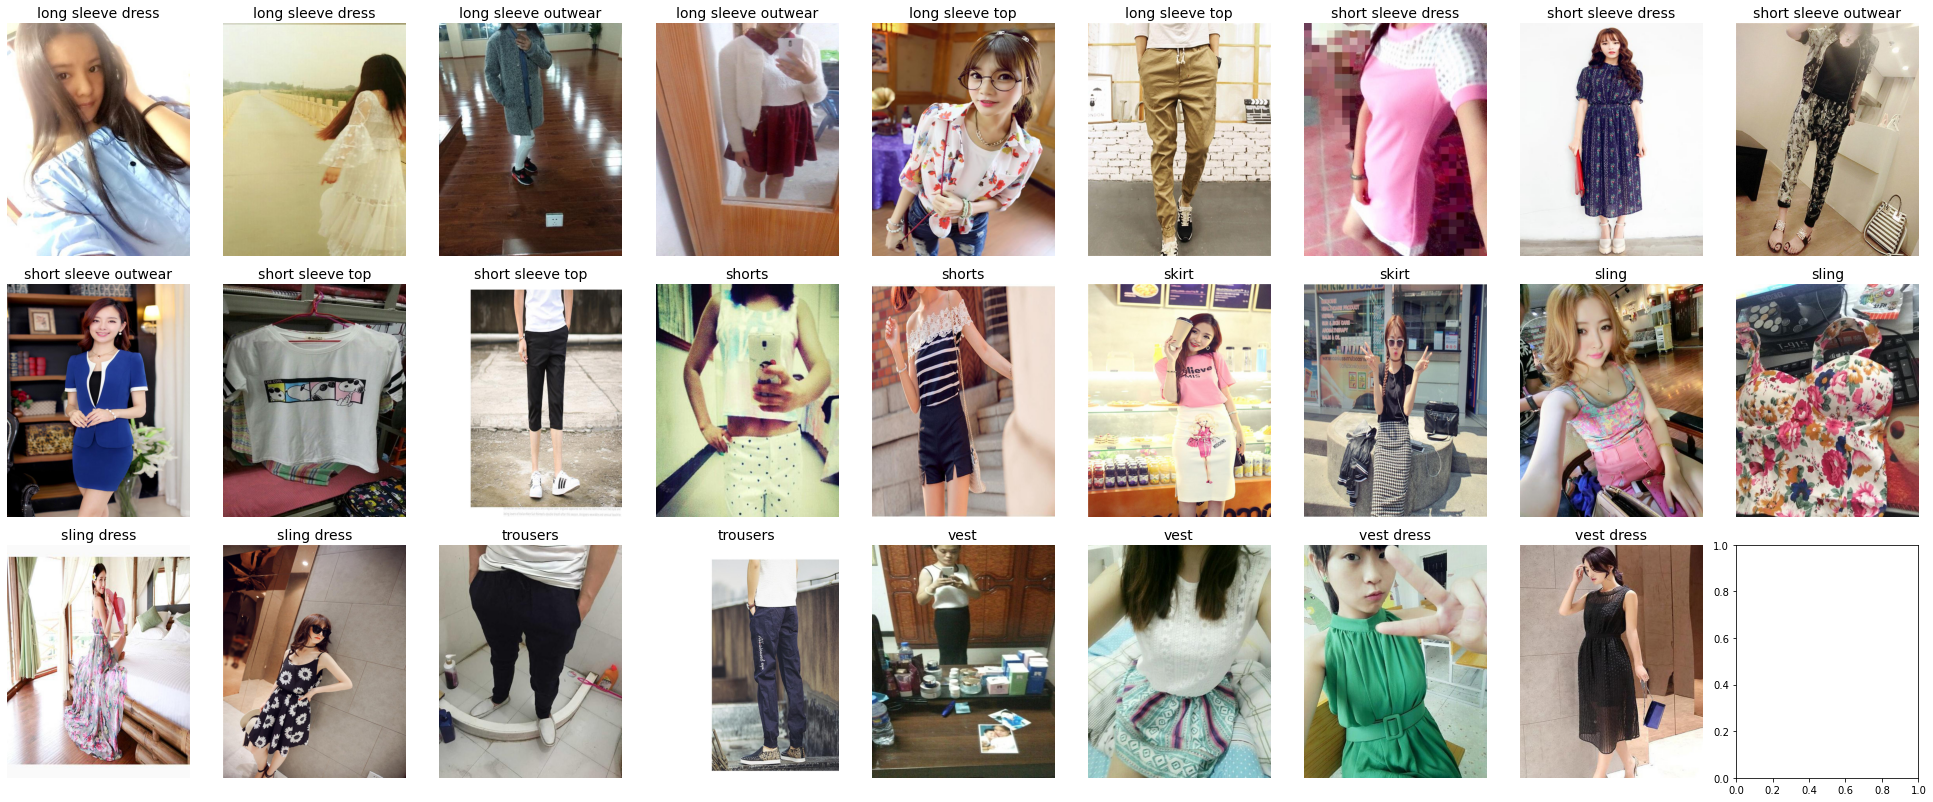

In [9]:
def _samples_per_category(df: pd.DataFrame,
                          column: str,
                          n_samples: int = 7) -> pd.DataFrame:
    return df.groupby(column)\
             .apply(lambda x: x.sample(n_samples))\
             .reset_index(level=0, drop=True)\
             .reset_index()
    

column = 'category_name'
display_instances(_samples_per_category(df, column, n_samples=2),
                  title_column=column,
                  n_cols=9)

<AxesSubplot:>

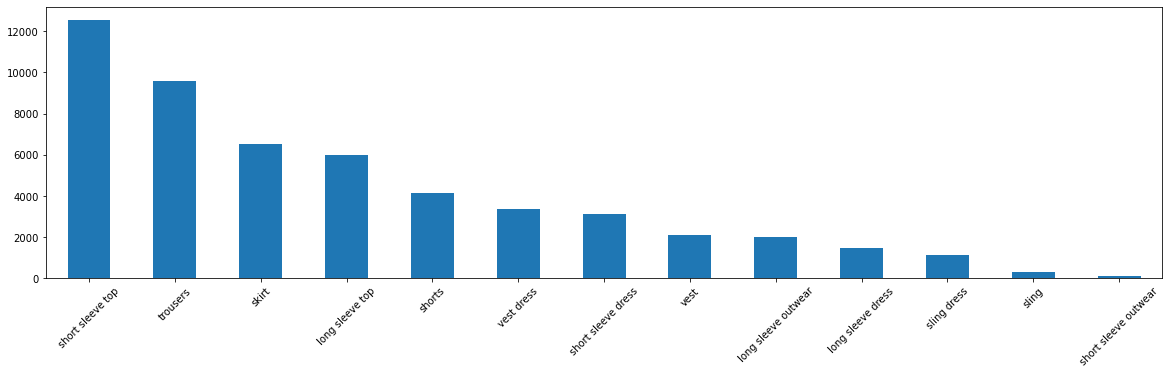

In [14]:
df[column].value_counts().plot.bar(figsize=(20,5), rot=45)

In [15]:
df[column].value_counts()

short sleeve top        12556
trousers                 9586
skirt                    6522
long sleeve top          5966
shorts                   4167
vest dress               3352
short sleeve dress       3127
vest                     2113
long sleeve outwear      2011
long sleeve dress        1477
sling dress              1149
sling                     322
short sleeve outwear      142
Name: category_name, dtype: int64

Significant data biasing

### Display image by viewpoint information

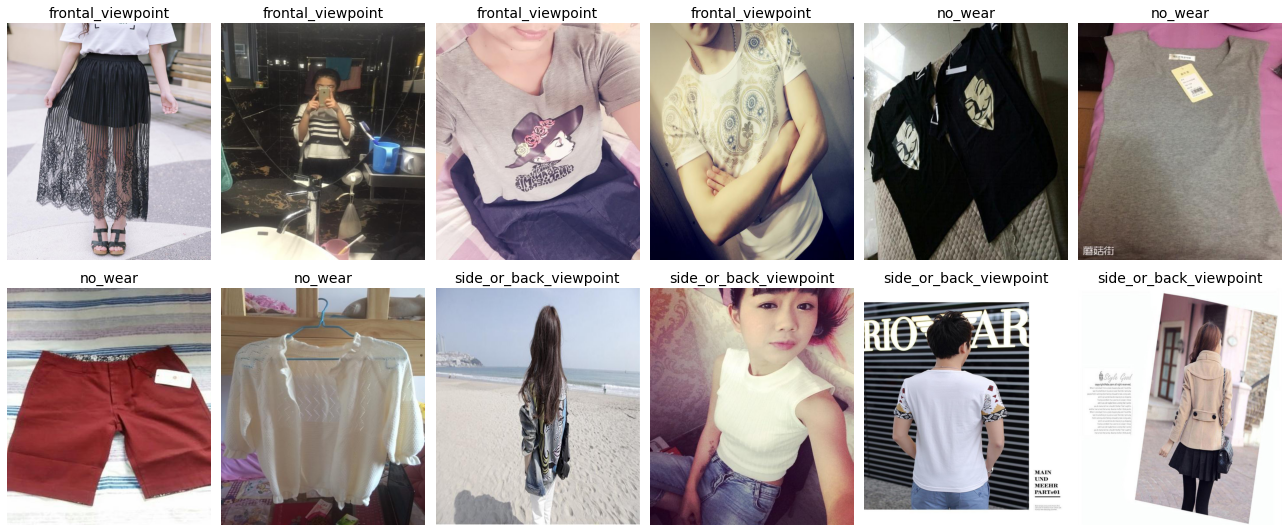

In [17]:
column = 'viewpoint_categorical'
display_instances(_samples_per_category(df, column, n_samples=4),
                  title_column=column,
                  n_cols=6)

<AxesSubplot:>

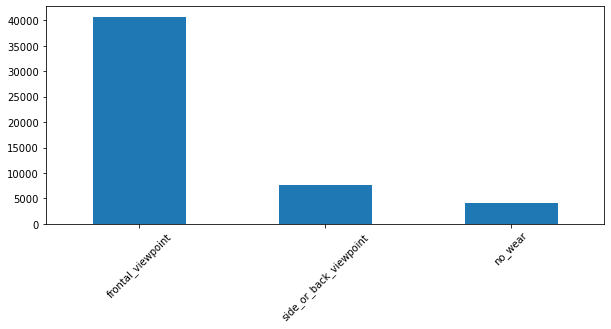

In [18]:
df[column].value_counts().plot.bar(figsize=(10, 4), rot=45)

Most of the images fall in frontal category.

### Display image by scale information

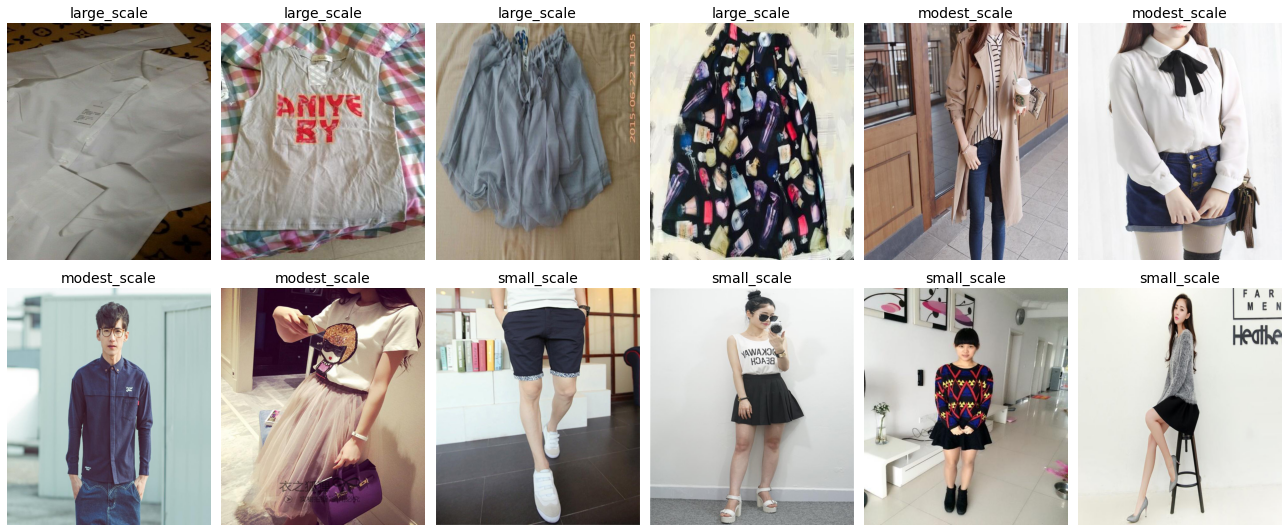

In [19]:
column = 'scale_categorical'
display_instances(_samples_per_category(df, column, n_samples=4),
                  title_column=column,
                  n_cols=6)

<AxesSubplot:>

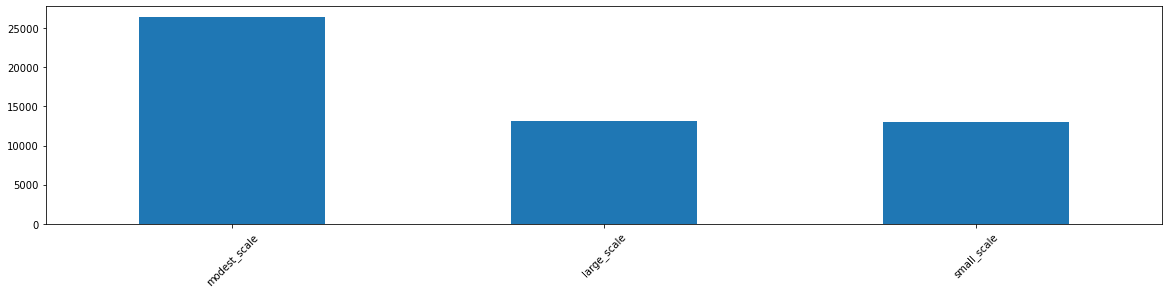

In [20]:
df[column].value_counts().plot.bar(figsize=(20, 4), rot=45)

### Display image by zoom-in information

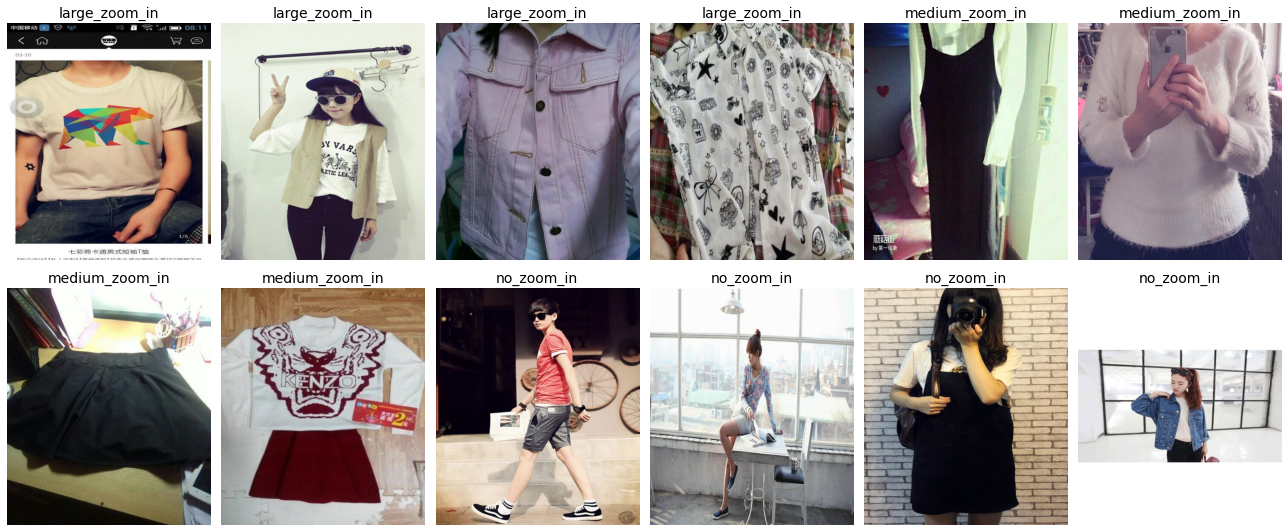

In [21]:
column = 'zoom_in_categorical'
display_instances(_samples_per_category(df, column, n_samples=4),
                  title_column=column,
                  n_cols=6)

<AxesSubplot:>

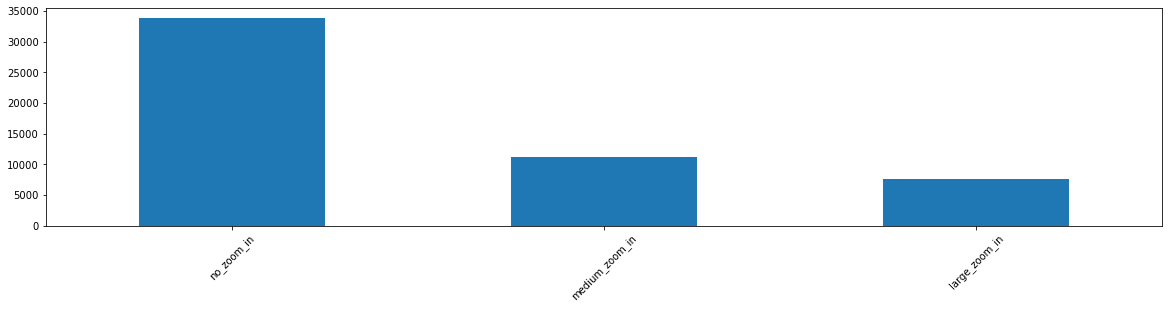

In [22]:
df[column].value_counts().plot.bar(figsize=(20, 4), rot=45)

## Clothing elements per image: stats

In [27]:
clothes_per_image = df.groupby('image_path')['category_id'].count()
mean, std = clothes_per_image.mean(), clothes_per_image.std()
print(f'Clothes per image: {mean:.2f} +- {std:.2f}')

Clothes per image: 1.63 +- 0.55


In [28]:
clothes_per_image

image_path
../data/fs2\image\000001.jpg    2
../data/fs2\image\000002.jpg    2
../data/fs2\image\000003.jpg    1
../data/fs2\image\000004.jpg    1
../data/fs2\image\000005.jpg    1
                               ..
../data/fs2\image\032149.jpg    1
../data/fs2\image\032150.jpg    1
../data/fs2\image\032151.jpg    1
../data/fs2\image\032152.jpg    1
../data/fs2\image\032153.jpg    1
Name: category_id, Length: 32153, dtype: int64

## Mask generation

Compute mask image from examples.

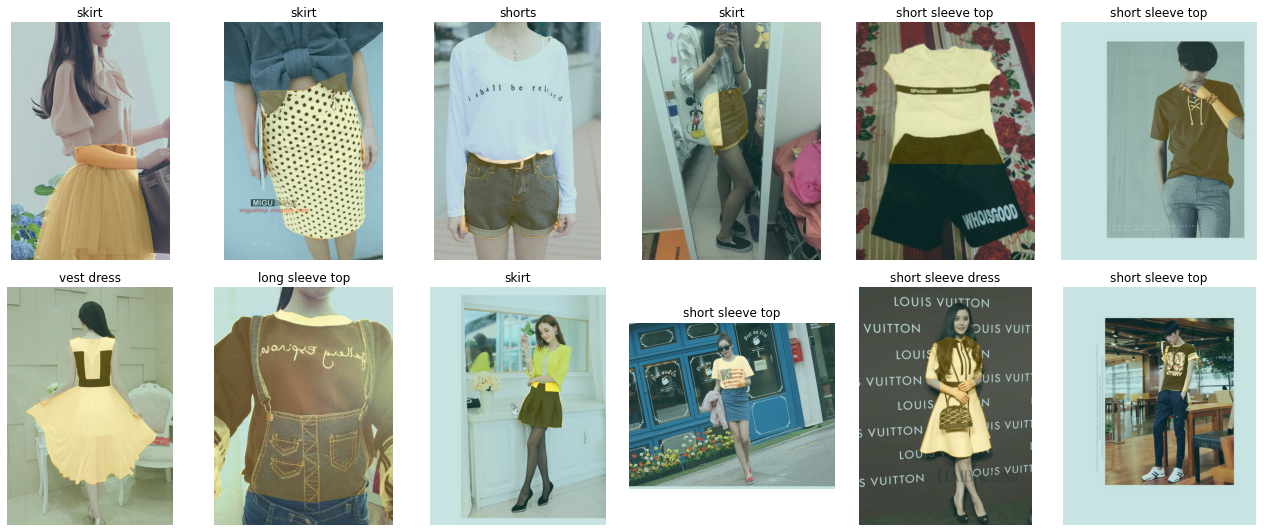

In [30]:
def _display_masks(image: np.ndarray, masks: List, ax=None):
    # Display image
    if ax is not None:
        axis = ax
    else:
        plt.figure(figsize=(8, 15))
        axis = plt
    axis.imshow(image)
    
    # Display all masks
    for mask in masks:
        axis.imshow(mask, alpha=0.25, vmin=-1.0, vmax=1.0)

        
def instance_to_mask(row: pd.Series) -> np.ndarray:
    image = skimage.io.imread(row['image_path'])
    image_height, image_width = image.shape[:2]
    return get_mask(image_height,
                    image_width,
                    polygons=row['segmentation'],
                    category_id=int(row['category_id']))


def display_instance_mask(row: pd.Series, ax) -> None:
    masks = [instance_to_mask(row)]
    image = skimage.io.imread(row['image_path'])
    _display_masks(image, masks, ax=ax)
    ax.set_title(row["category_name"])
    ax.axis('off')
    
samples = df.sample(12)
display_instances(samples, display_fn=display_instance_mask, n_cols=6)

We see that, in many cases, polygons defining the clothing area are quite sharp and do not properly wrap the clothes margin.

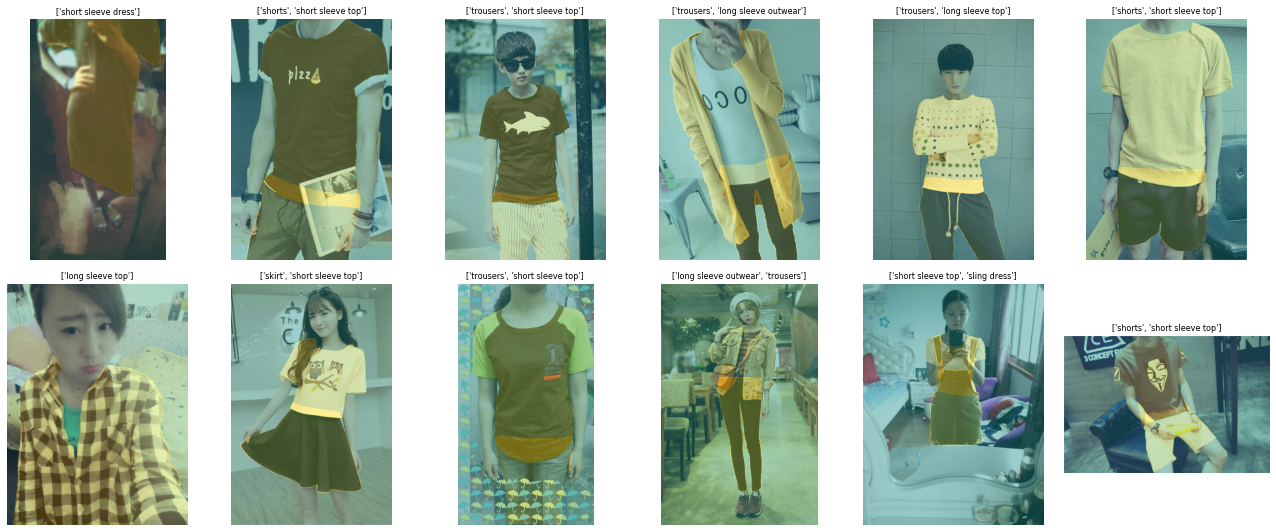

In [31]:
def display_all_instance_masks(row: pd.Series, ax) -> None:
    items = df[df.index == row.name]
    masks = items.apply(instance_to_mask, axis=1).values.tolist()
    image = skimage.io.imread(row['image_path'])
    _display_masks(image, masks, ax=ax)
    # Displau call categories
    categories = items["category_name"].values.tolist()
    ax.set_title(f'{categories}', fontsize=8)
    ax.axis('off')

samples = df.sample(12)
display_instances(samples, display_fn=display_all_instance_masks, n_cols=6)